In [1]:
# Imports
import os
import sys
import pandas as pd
import seaborn as sb

# Custom Imports
sys.path.insert(0, '../../')
import stats_toolbox as st
from stats_toolbox.utils.data_loaders import load_fem_preg_2002

# Graphics setup 
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load and Clean Data
df = load_fem_preg_2002('../data')
full_term = df[df['prglngth'] >= 37]
weights = df.birthwgt_kg.dropna()

live = df[df.outcome == 1]
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

# Construction a CDF

The CDF is the function that maps from a value to its cumulative probability.

* `prob(x)`: Given a value $x$, computes the probability $p = CDF(x)$ that is the fraction of the sample less than or equal to $x$. The bracket operator is equivalent.
* `value(p)`: Given a probability $p$, computes the corresponding value, $x$; that is, the inverse CDF of p.

For convienience, it also contains the follwing methods for working with percentiles:

* `percentile_rank(x)`: Given a value $x$, computes its percentile rank, $100 \times CDF(x)$.
* `percentile(rank)`: Given a percentile rank $rank$, computes the corresponding value, $x$. Equivalent to `value(rank/100)`.

In [3]:
prglngth_cdf = st.Cdf(live.prglngth, label='Pregnancy length')

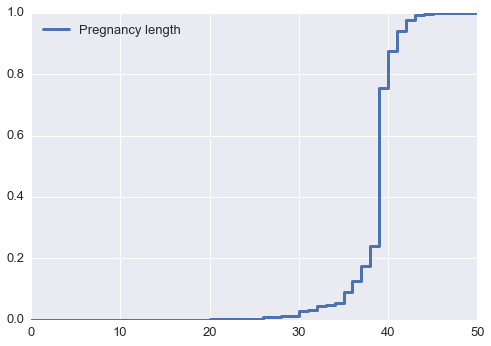

In [4]:
prglngth_cdf.plot()

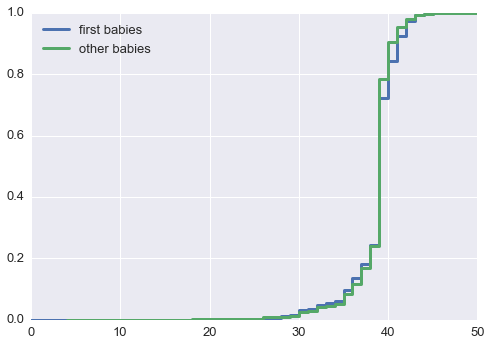

In [5]:
firsts_cdf = st.Cdf(firsts.prglngth, label='first babies')
others_cdf = st.Cdf(others.prglngth, label='other babies')
fig = st.multiplot([firsts_cdf, others_cdf], title='CDF of Pregnancy Length')

# Methods

## Sampling

Cdf also provides `sample`, which takes an integer, $n$, and returns a list of n
values chosen at random from the Cdf. 

# Analysing Empirical CDFs

## Testing if a distribution is Exponential

If an event is equally likely to happen over a time period, then the inter arrival time of the events is observed as an exponential distribution. The parameter, λ, can be interpreted as a rate; that is, the number of events that occur, on average, in a unit of time. The mean of an exponential distribution is $1/λ$

One way to test whether a sample is exponentialy distributed is to plot the complementary CDF, which is $1 − CDF(x)$, on a log-y scale. For data from an exponential distribution, the result is a straight line. 

The exponential distribution is given by 

$$CDF(x) = 1 − e^{−λx}$$

which you can rearange to the following 

$$CDF(x) - 1 = − e^{−λx}$$
$$ln(CDF(x) - 1) = -λx ln(e)$$
$$ln(CDF(x) - 1) = -λx$$

So the result should be a straight line with gradient λ.


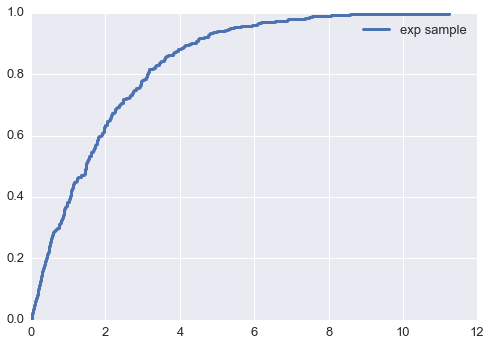

In [6]:
import numpy as np

sample_exp = np.random.exponential(2, 300)
exp_cdf = st.Cdf(sample_exp, label='exp sample')
exp_cdf.plot()

The plot function for cdfs can take a `complement` argument, and a `yscale` argument 

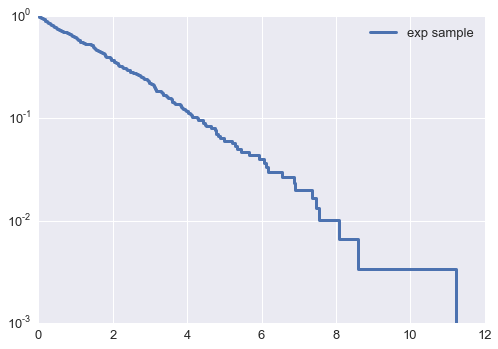

In [7]:
exp_cdf.plot(complement=True, yscale='log')
# another way is to use the transform argument
# cdf.plot(transform='exponential')

## Testing if a distribution is Normal

One way is to see how there cdfs compare.

In [8]:
# calculate mean and std
pmf_weights = st.Pmf(live.birthwgt_kg, label='Weights')
print(pmf_weights.mean(), pmf_weights.std())

3.29563094335 0.6387553004258345


`render_normal_cdf` takes parameters `mean`, `std`, `low`, `high` and `n`.

In [9]:
# Make a nornal cdf with the same values for mean and std
xs, ps = st.utils.data_generators.render_normal_cdf(pmf_weights.mean(), pmf_weights.std(), 0, 6, n=1000)
cdf_normal = st.Cdf(xs, ps, label='Normal')

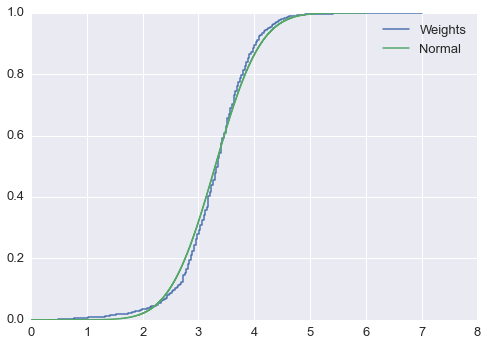

In [10]:
# Generate cdf and plot both on same axis
cdf_weights = pmf_weights.to_cdf()
fig = st.multiplot([cdf_weights, cdf_normal], plt_kwds={'linewidth':1.5})

## The Normal Probability Plot 

No such easy transform to test analytical distribution against empirical as with exponential. However here’s an easy way:
1. Sort the values in the sample.
2. From a standard normal distribution (μ = 0 and σ = 1), generate a random sample with the same size as the sample, and sort it.
3. Plot the sorted values from the sample versus the random values.

If the distribution of the sample is approximately normal, the result is a straight line with intercept mu and slope sigma.

In [11]:
norm1 = np.random.normal(1, 2, 200)
norm2 = np.random.normal(1, 5, 200)
norm3 = np.random.normal(3, 2, 200)
exp1 = np.random.exponential(5, 200)

c1 = st.Cdf(norm1, label='Norm($\mu=1$, $\sigma=2$)')
c2 = st.Cdf(norm2, label='Norm($\mu=1$, $\sigma=5$)')
c3 = st.Cdf(norm3, label='Norm($\mu=3$, $\sigma=2$)')
c4 = st.Cdf(exp1, label='Exp($\lambda=5$)')

`normal_probability_plot` takes a single sequence or cdf object, or alternatively a list of sequences or cdf objects,. All are plotted ont he same axis, but the fit line is only for the first object/sequence in the given list. A list of lables can optionally be given to override the defaults.

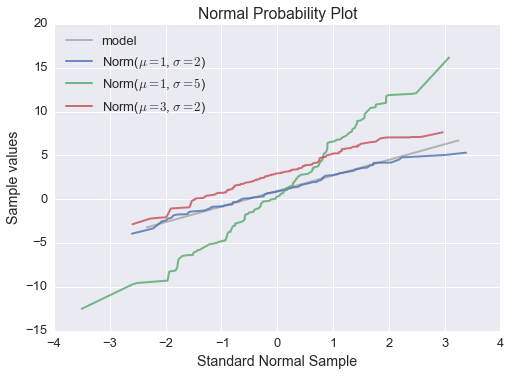

In [12]:
fig = st.normal_probability_plot([c1, c2, c3], linewidth=2)

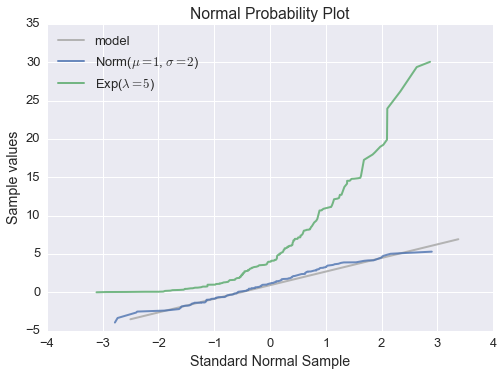

In [13]:
fig = st.normal_probability_plot([c1, c4], linewidth=2)

## Testing if a distribution is log Normal

The cdf for a log nognormaly distributed variable is:
    
$$CDF_{lognormal}(x) = CDF_{normal}(log(x))$$


If a sample is approximately lognormal and you plot its CDF on a log-x scale, it will have the characteristic shape of a normal distribution. To test how well the sample fits a lognormal model, you can make a normal probability plot using the log of the values in the sample.

In [14]:
# Sample data from Behavioral Risk Factor Surveillance System (BRFSS)
brfss = pd.read_csv('../data/BRFSS.csv')
weights = brfss.wtkg2.dropna()

In [15]:
brfss_weights_cdf = st.Cdf(weights , label='Weights kg')

# Make a nornal cdf with the same values for mean and std
xs, ps = st.utils.data_generators.render_normal_cdf(weights.mean(), weights.std(), 0, 200, n=1000)
norm_cdf = st.Cdf(xs, ps, label='Normal CDF')

From comparing the standad cdfs, difference is not so obvious, though if x is now plotted with a log scale on the x axis, the normal model fits slightly better 

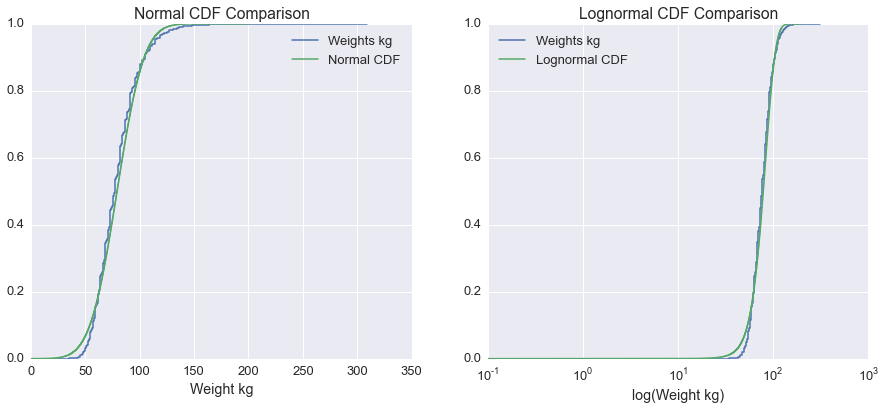

In [16]:
# Use subplots to generate all axes objects
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
# These can then be passed to multiplot, or any other obj.plot() method with the 'axes' keyword
norm_cdf.label = 'Normal CDF'
fig = st.multiplot([brfss_weights_cdf, norm_cdf], 
                   plt_kwds={'linewidth':1.5, 'title': 'Normal CDF Comparison', 'xlabel':'Weight kg'}, 
                   axes=ax1)
norm_cdf.label = 'Lognormal CDF'
fig = st.multiplot([brfss_weights_cdf, norm_cdf], 
                   plt_kwds={'linewidth':1.5, 'xscale': 'log', 
                            'title': 'Lognormal CDF Comparison', 'xlabel':'log(Weight kg)'}, 
                   axes=ax2)

This differnce is more obvious though when visualised as a normal probability plot

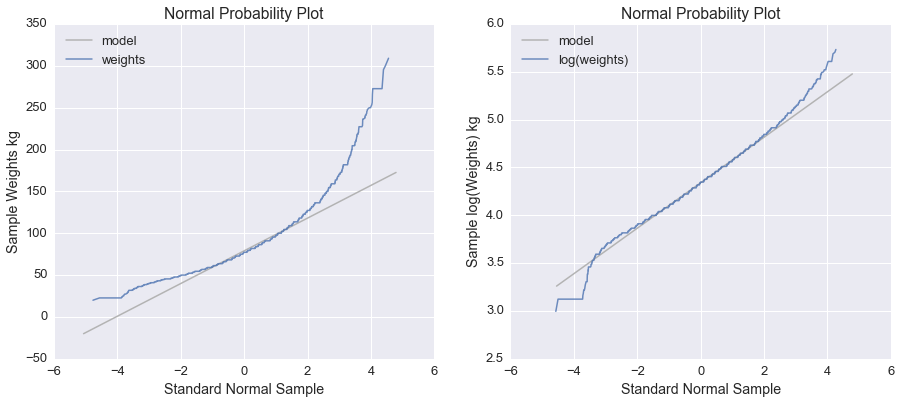

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
fig = st.normal_probability_plot(weights, labels=['weights'], axes=ax1, ylabel='Sample Weights kg')
fig = st.normal_probability_plot(np.log(weights), labels=['log(weights)'],  axes=ax2, ylabel='Sample log(Weights) kg')

## Testing Whether a Sample is Pareto Distributed

The CDF of the Pareto distribution is:
􏰄
$$CDF(x) = 1 − \left(\frac{x}{x_{m}}\right)^{-α}$$

The parameters $x_{m}$ and α determine the location and shape of the distribution. $x_{m}$ is the minimum possible value.

There is a simple visual test that indicates whether an empirical distribution fits a Pareto distribution: on a log-log scale, the CCDF looks like a straight line.

This is because taking the log of both sides yields:
$$logy ≈ −α(log(x)−log(x_{m}))$$

So if you plot log y versus log x, it should look like a straight line with slope $−α$ and intercept $α log x_{m}$.

In [42]:
import scipy
xs = scipy.stats.pareto.rvs(5, 3, size=1000)

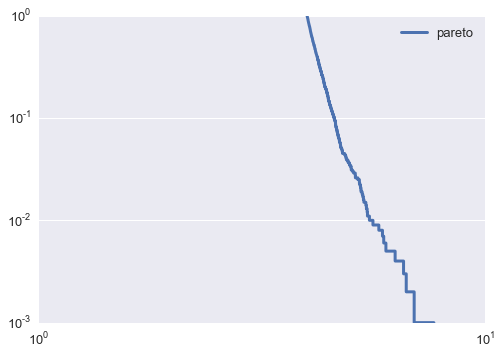

In [43]:
cdf = st.Cdf(xs, label='pareto')
cdf.plot(xscale='log', yscale='log', complement=True)
# or equivilantly with 
# cdf.plot(transform='pareto')

##Generating Random Numbers

If there is an efficient way to compute the inverse CDF, we can generate random values with the appropriate distri- bution by choosing $p$ from a uniform distribution between 0 and 1, then choosing $x = ICDF(p)$.

For example, the CDF of the exponential distribution is 
$$p = 1 − e^{−λx}$$
Solving for x yields:
$$x = − log(1 − p)/λ$$
So in Python we can write

    def expovariate(lam):
        p = random.random()
        x = -math.log(1-p) / lam
        return x


**Note**: Since log of zero is undefined, we have to be a little careful. The implementation of random.random can return 0 but not 1, so 1 − p can be 1 but not 0, so log(1-p) is always defined.